# First Level Analysis with Nilearn

[Nilearn](https://nilearn.github.io/stable/index.html) `GLM stats` module allows fast and easy MRI statistical analysis. It leverages `Nibabel` and other `Python` libraries.


## Accessing the preprocessed (fMRIprep) data

BIDS applications, such as `fMRIprep`, output data into a data structure similar to `BIDS` organization principals. And these data can also be inspected using [PyBIDS](https://bids-standard.github.io/pybids/index.html).


In [5]:
import os
from bids.layout import BIDSLayout

ds_path = '/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids'

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(ds_path, derivatives = True)

With the `PyBIDS` we can easlily find the proprocessed files that we'd need for the analysis. Let's get the `sub-04` preprocessed anatomical and functional `MNI152NLin2009cAsym` space image files. 

In [6]:
sID = '04'
anat = layout.get(subject=sID, datatype='anat', space='MNI152NLin2009cAsym', desc='preproc', extension='.nii.gz', \
                  return_type='filename')
print('Subject''s', sID, 'preprocessed anatomical image:')
print(*anat, sep='\n')

bold = layout.get(subject=sID, datatype='func', space='MNI152NLin2009cAsym', desc='preproc', extension='.nii.gz', \
                 return_type='filename')
print('\nSubject''s', sID, 'preprocessed functional images:')
print(*bold, sep='\n')

Subjects 04 preprocessed anatomical image:
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/anat/sub-04_acq-mprage_space-MNI152NLin2009cAsym_res-2_desc-preproc_T1w.nii.gz

Subjects 04 preprocessed functional images:
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-1_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-2_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-3_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmripr

## Model components

A GLM model has outcome variable (the BOLD signal/ourMRI images) and predictors (Events, Confounds).

### MRI images
We need to specify which images we want to analyse. 

Here we will analyse `sub-04` 9 functional runs. We will also specify the subject's anatomical image (warped to the standard space) to use it as a background image when plotting results. 

### Events

We also need to specify the events that were happaning during the functional acquisitions. The events files are stored in the `func` foder and we can find them with `PyBIDS`.

In [7]:
events = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
print('Subject''s', sID, 'event files:')
print(*events, sep='\n')

Subjects 04 event files:
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-01_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-02_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-03_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-04_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-05_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-06_events.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/sub-04/func/sub-04_task-facerecognition_run-07

Let's display the first rows of events of the first run.

In [8]:
import pandas as pd # pandas is a library for data manipulation 
events_run1 = pd.read_table(events[0])
events_run1.head()

,onset,duration,circle_duration,trial_type,trigger,button_pushed,response_time,stim_file
0,0.000,0.983,0.492,SCRAMBLED,17,7,1.553,func/s008.bmp
1,3.240,0.971,0.488,SCRAMBLED,17,7,1.904,func/s004.bmp
2,6.498,0.832,0.409,SCRAMBLED,18,4,1.548,func/s004.bmp
3,9.538,0.898,0.441,FAMOUS,5,4,1.685,func/f002.bmp
4,12.644,0.993,0.445,FAMOUS,6,4,1.482,func/f002.bmp


### Confounds

Usually, we also want to include confounds computed during preprocessing (e.g., motion artifacts) as regressors of no interest. The confounds are computed by `fmriprep` and can be found in `derivatives/fmriprep/{sub}/func/` directory.

Let's find these files with `PyBIDS`.

In [9]:
confounds = layout.get(subject=sID, datatype='func', desc='confounds', extension=".tsv", return_type='filename')
print('Subject''s', sID, 'confound files:')
print(*confounds, sep='\n')

Subjects 04 confound files:
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-1_desc-confounds_timeseries.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-2_desc-confounds_timeseries.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-3_desc-confounds_timeseries.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-4_desc-confounds_timeseries.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition/data/bids/derivatives/fmriprep/sub-04/func/sub-04_task-facerecognition_run-5_desc-confounds_timeseries.tsv
/imaging/correia/dace/training/summer-school/Example_v03/FaceRecognition

Let's get a list of all confound names.

In [10]:
confounds_run1 = pd.read_table(confounds[0])
list(confounds_run1)

['global_signal',
 'global_signal_derivative1',
 'global_signal_power2',
 'global_signal_derivative1_power2',
 'csf',
 'csf_derivative1',
 'csf_power2',
 'csf_derivative1_power2',
 'white_matter',
 'white_matter_derivative1',
 'white_matter_derivative1_power2',
 'white_matter_power2',
 'csf_wm',
 'tcompcor',
 'std_dvars',
 'dvars',
 'framewise_displacement',
 'rmsd',
 't_comp_cor_00',
 't_comp_cor_01',
 't_comp_cor_02',
 't_comp_cor_03',
 't_comp_cor_04',
 'c_comp_cor_00',
 'c_comp_cor_01',
 'c_comp_cor_02',
 'c_comp_cor_03',
 'c_comp_cor_04',
 'c_comp_cor_05',
 'c_comp_cor_06',
 'c_comp_cor_07',
 'w_comp_cor_00',
 'w_comp_cor_01',
 'w_comp_cor_02',
 'w_comp_cor_03',
 'w_comp_cor_04',
 'w_comp_cor_05',
 'w_comp_cor_06',
 'w_comp_cor_07',
 'w_comp_cor_08',
 'w_comp_cor_09',
 'w_comp_cor_10',
 'w_comp_cor_11',
 'w_comp_cor_12',
 'w_comp_cor_13',
 'w_comp_cor_14',
 'w_comp_cor_15',
 'w_comp_cor_16',
 'w_comp_cor_17',
 'w_comp_cor_18',
 'w_comp_cor_19',
 'w_comp_cor_20',
 'w_comp_cor_21',


In [11]:
# Total number of confounds created:
len(list(confounds_run1))

192

The fMRIPrep pipeline generates a large array of possible confounds. The most well established confounding variables in neuroimaging are the six head-motion parameters (three rotations and three translations) - the common output of the head-motion correction (also known as realignment) of popular fMRI preprocessing software such as SPM or FSL. Let's include them in our model. 

Let's display these confounds of the first run.

In [12]:
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_run1[confounds_of_interest]

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z
0,0.024782,-0.035220,-0.060713,-0.001181,0.000694,-0.000539
1,0.018112,0.026438,-0.054200,-0.001886,0.000706,-0.000539
2,0.015412,-0.025317,-0.050592,-0.001655,0.000699,-0.000539
3,0.016319,-0.059473,-0.060723,-0.001143,0.000281,-0.000539
4,0.020953,0.037358,-0.057378,-0.001199,0.000339,-0.000539
...,...,...,...,...,...,...
203,-0.076559,0.071594,-0.059187,0.002741,-0.000072,-0.000603
204,-0.067033,0.166644,-0.045246,0.002323,-0.000442,-0.000629
205,-0.067025,0.037199,-0.045189,0.003095,-0.000442,-0.000669
206,-0.067015,0.189709,-0.011324,0.002527,-0.000442,-0.000535


Now we need to get the confounds of interest of all runs. These will be included in our `GLM` design. We will create a list of counfaund tables (9 tables). 

In [13]:
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)
    
print(type(confounds_glm))
print(len(confounds_glm))

<class 'list'>
9


## Performing the GLM analysis

It is now time to create and estimate a ``FirstLevelModel`` object, that will generate the *design matrix*.



### Creating the First Level Model

In [14]:
from nilearn.glm.first_level import FirstLevelModel

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/__init__.py:55: FutureWarning: The nilearn.glm module is experimental. It may change in any future release of Nilearn.
  warn('The nilearn.glm module is experimental. '


There are a lot of important parameters one needs to define within a `FirstLevelModel` and the majority of them will have a prominent influence on your results. [Check the documentation!](https://nilearn.github.io/stable/modules/generated/nilearn.glm.first_level.FirstLevelModel.html)

For the model specification, we need the TR of the functional images, luckily we can extract this information with `PyBIDS`.

In [15]:
# Get the TR
TR = layout.get_tr()
print('TR:', TR)

TR: 2.0


Now we can specify the model with the parameters of our choice. Here we will specify the folowing:
* **t_r**, of course
* **slice_time_ref**: *This parameter indicates the time of the reference slice used in the slice timing preprocessing step of the experimental runs. It is expressed as a percentage of the t_r (time repetition), so it can have values between 0. and 1. Default=0.* Let's see if we get this information from our fMRIPrep Methods. 
* **hrf_model**: defines the HRF model to be used.
    * 

        ‘spm’: This is the HRF model used in SPM. See nilearn.glm.first_level.spm_hrf.

        ‘spm + derivative’: SPM model plus its time derivative. This gives 2 regressors. See nilearn.glm.first_level.spm_hrf, and nilearn.glm.first_level.spm_time_derivative.

        ‘spm + derivative + dispersion’: Idem, plus dispersion derivative. This gives 3 regressors. See nilearn.glm.first_level.spm_hrf, nilearn.glm.first_level.spm_time_derivative, and nilearn.glm.first_level.spm_dispersion_derivative.

        ‘glover’: This corresponds to the Glover HRF. See nilearn.glm.first_level.glover_hrf.

        ‘glover + derivative’: The Glover HRF + time derivative. This gives 2 regressors. See nilearn.glm.first_level.glover_hrf, and nilearn.glm.first_level.glover_time_derivative.

        ‘glover + derivative + dispersion’: Idem, plus dispersion derivative. This gives 3 regressors. See nilearn.glm.first_level.glover_hrf, nilearn.glm.first_level.glover_time_derivative, and nilearn.glm.first_level.glover_dispersion_derivative.

        ‘fir’: Finite impulse response basis. This is a set of delayed dirac models.

* **drift_model**: specifies the desired drift model for the design matrices. It can be ‘polynomial’, ‘cosine’ or None. Default=’cosine’.
* **high_pass**: specifies the cut frequency of the high-pass filter in Hz for the design matrices. Used only if drift_model is ‘cosine’. Default=0.01 (1/128, as in SPM).
* **smoothing_fwhm**: the full-width at half maximum in millimeters of the spatial smoothing to apply to the signal (smoothing was not done in fMRIPrep!).
* **noise_model**: {‘ar1’, ‘ols’} The temporal variance model. Default=’ar1’.





In [16]:
fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = TR/2,
    hrf_model = 'spm',
    drift_model = 'Cosine',
    high_pass = 1./128,
    smoothing_fwhm = 6,
    noise_model = 'ar1'
)

### Fitting the model

Now that we have specified the model, we can run it on our specified data. We need to include the list of our functional image files (we named that `bold`), the list of events timing files (we named that `events`), and the list of our confound tables (one per run; which we named `confounds_glm`).

In [17]:
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `trigger` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `circle_duration` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/si

/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `trigger` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `circle_duration` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `response_time` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/site-packages/nilearn/glm/first_level/experimental_paradigm.py:89: UserWarning: Unexpected column `stim_file` in events data will be ignored.
  warnings.warn(("Unexpected column `{}` in events "
/home/da05/.conda/envs/fMRI/lib/python3.9/si

### Inspecting the Design Matrix

We can now inspect the design matrix of our `GLM` model (rows represent time, and columns contain the predictors).

In [18]:
design_matrices = fmri_glm.design_matrices_

The `design_matrices` is a list of 9 tables (one per run). Let's look at the first run's design matrix.

In [19]:
design_matrices[0]

,FAMOUS,REST,SCRAMBLED,UNFAMILIAR,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,drift_1,drift_2,drift_3,drift_4,drift_5,drift_6,constant
2.0,0.000000,0.000000,0.018871,0.000000,0.024782,-0.035220,-0.060713,-0.001181,0.000694,-0.000539,0.098055,0.098047,0.098033,0.098013,0.097988,0.097957,1.0
4.0,0.000000,0.000000,0.158397,0.000000,0.018112,0.026438,-0.054200,-0.001886,0.000706,-0.000539,0.098033,0.097957,0.097832,0.097656,0.097430,0.097153,1.0
6.0,0.000000,0.000000,0.268038,0.000000,0.015412,-0.025317,-0.050592,-0.001655,0.000699,-0.000539,0.097988,0.097779,0.097430,0.096942,0.096316,0.095552,1.0
8.0,0.000000,0.000000,0.332236,0.000000,0.016319,-0.059473,-0.060723,-0.001143,0.000281,-0.000539,0.097921,0.097511,0.096828,0.095874,0.094653,0.093167,1.0
10.0,0.000007,0.000000,0.341275,0.000000,0.020953,0.037358,-0.057378,-0.001199,0.000339,-0.000539,0.097832,0.097153,0.096027,0.094456,0.092450,0.090017,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
408.0,-0.001504,0.000730,-0.003890,-0.037277,-0.076559,0.071594,-0.059187,0.002741,-0.000072,-0.000603,-0.097832,0.097153,-0.096027,0.094456,-0.092450,0.090017,1.0
410.0,-0.000606,-0.000347,-0.001860,-0.035984,-0.067033,0.166644,-0.045246,0.002323,-0.000442,-0.000629,-0.097921,0.097511,-0.096828,0.095874,-0.094653,0.093167,1.0
412.0,-0.000188,-0.000728,-0.000805,-0.026997,-0.067025,0.037199,-0.045189,0.003095,-0.000442,-0.000669,-0.097988,0.097779,-0.097430,0.096942,-0.096316,0.095552,1.0
414.0,-0.000046,-0.000712,-0.000320,-0.017098,-0.067015,0.189709,-0.011324,0.002527,-0.000442,-0.000535,-0.098033,0.097957,-0.097832,0.097656,-0.097430,0.097153,1.0


From the design matrix, we can extract and plot the expected signal of our conditions. Here we will plot it for the first run.

<AxesSubplot: title={'center': 'Expected responses per condition'}, xlabel='Seconds'>

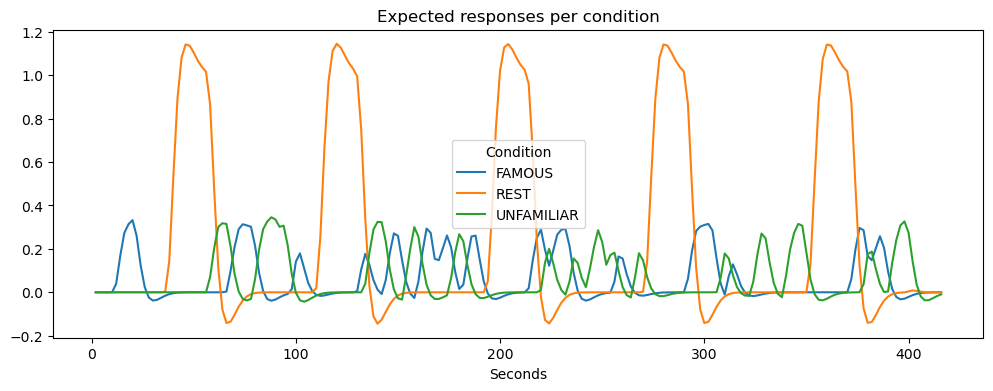

In [21]:
dm = design_matrices[0][['FAMOUS', 'REST', 'UNFAMILIAR']]
dm.columns.name = 'Condition'
dm.index.name = 'Seconds'
dm.plot(figsize=(12,4), title='Expected responses per condition')

**Q: How was this expected signal obtained?**

<AxesSubplot: title={'center': 'Expected signal'}, xlabel='Seconds'>

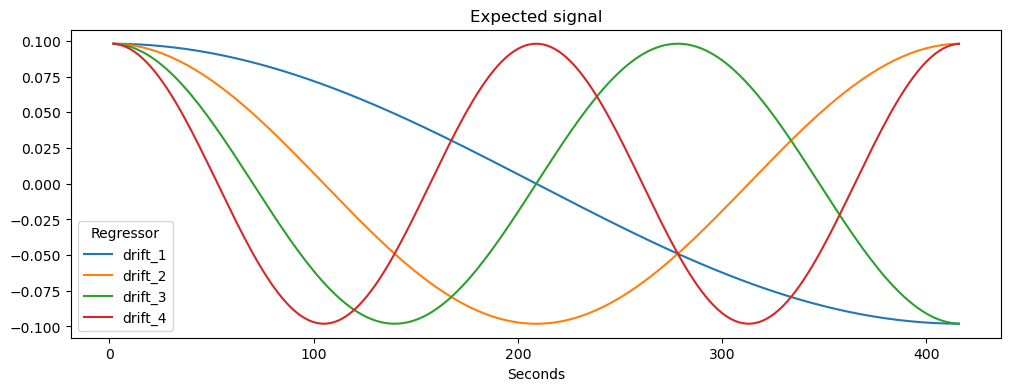

In [22]:
# let's see how the modelled noise regressors look
dm = design_matrices[0][['drift_1','drift_2', 'drift_3', 'drift_4']]
dm.columns.name = 'Regressor'
dm.index.name = 'Seconds'
dm.plot(figsize=(12,4), title='Expected signal')

We can also plot the actual design matrix (here again for the first run).

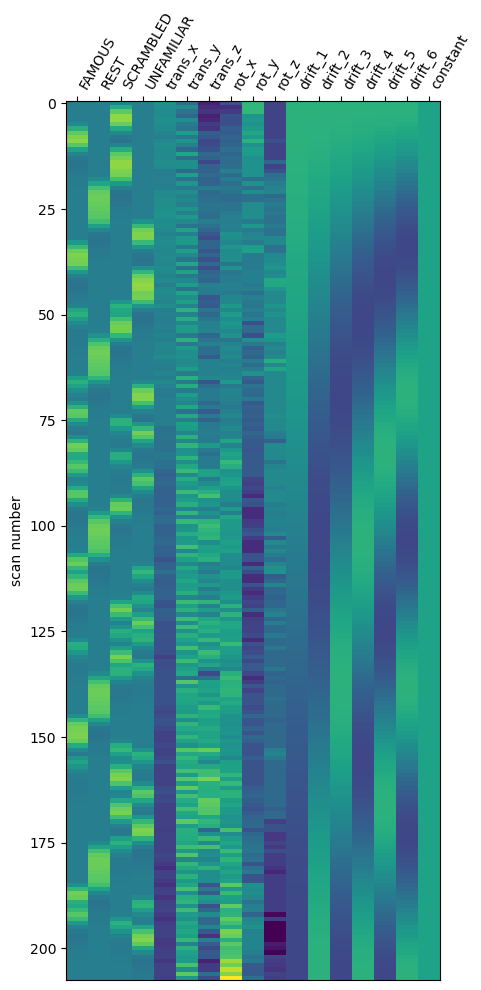

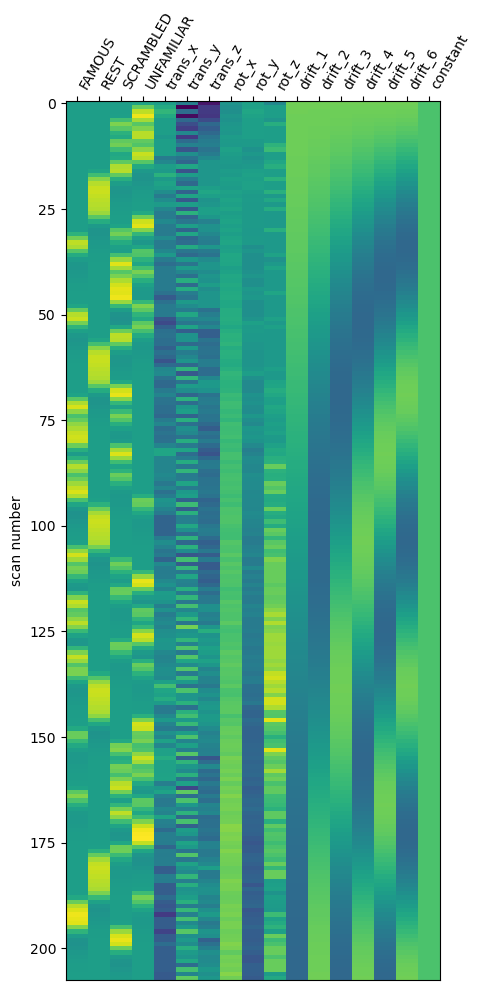

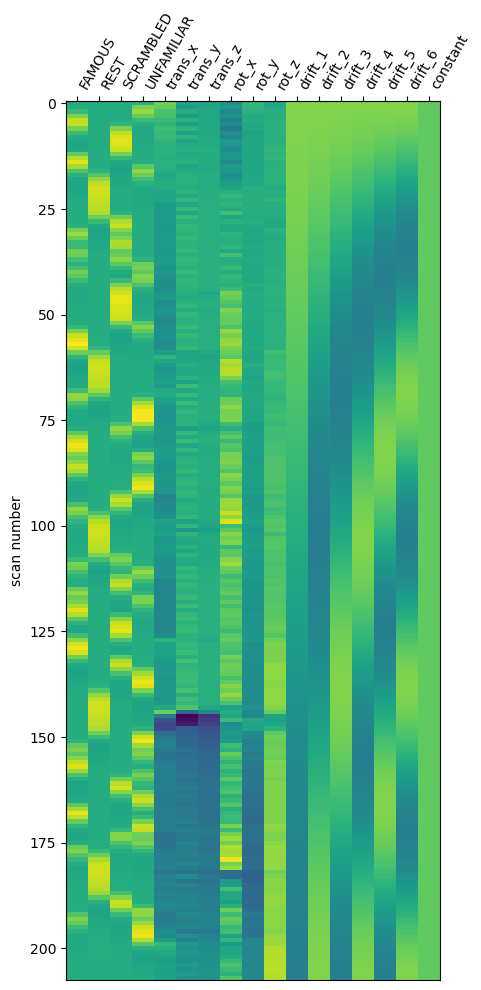

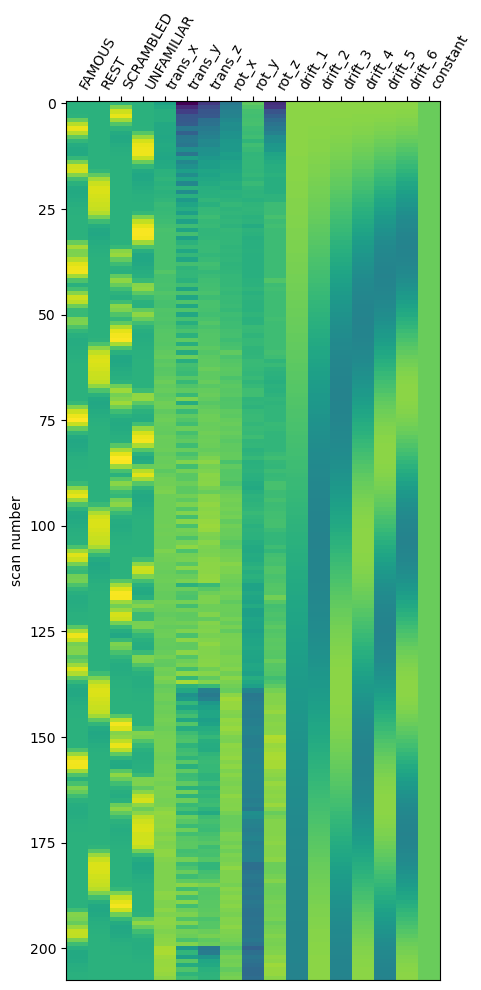

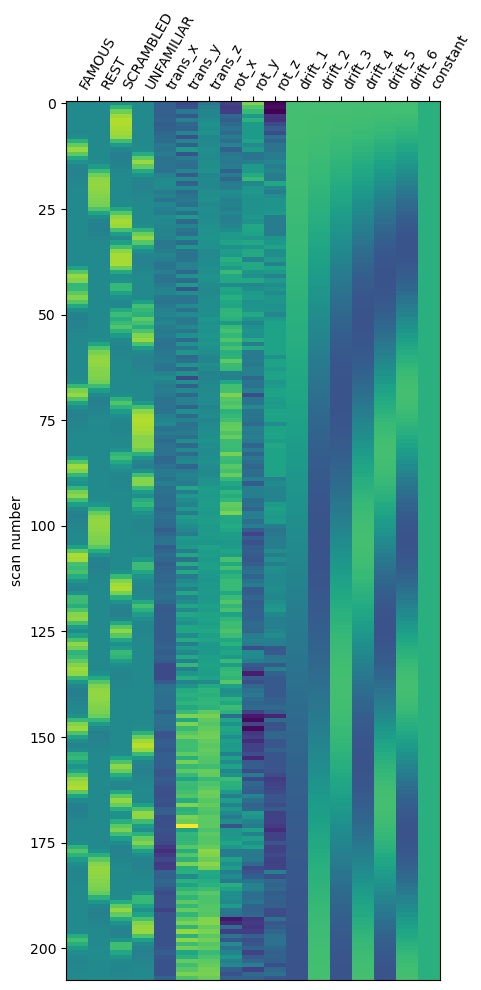

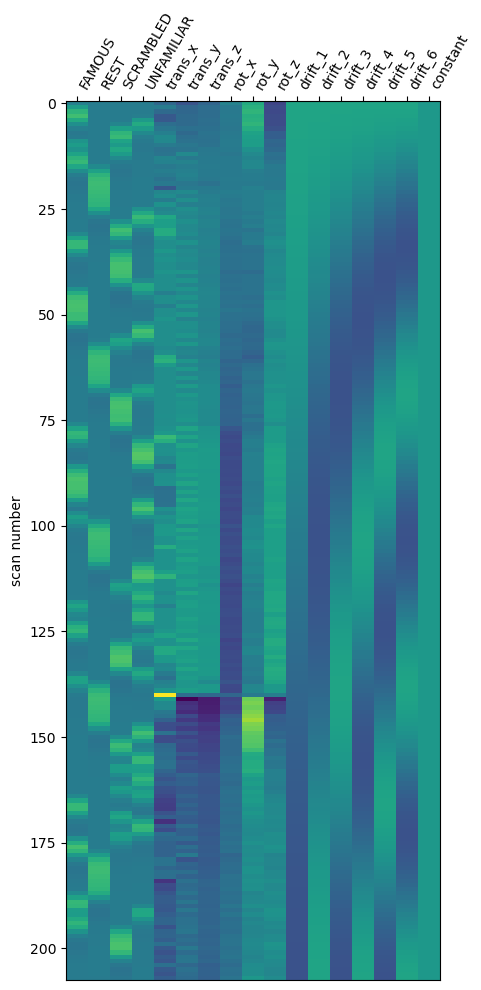

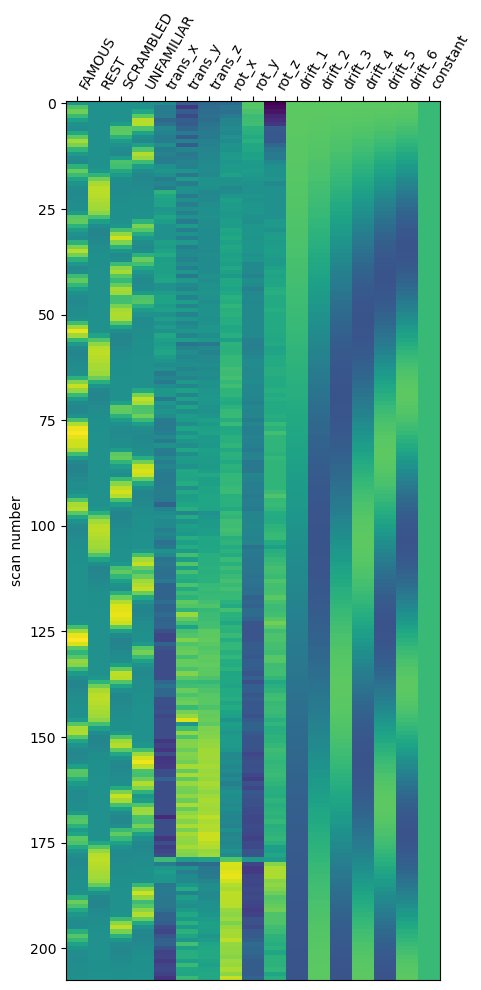

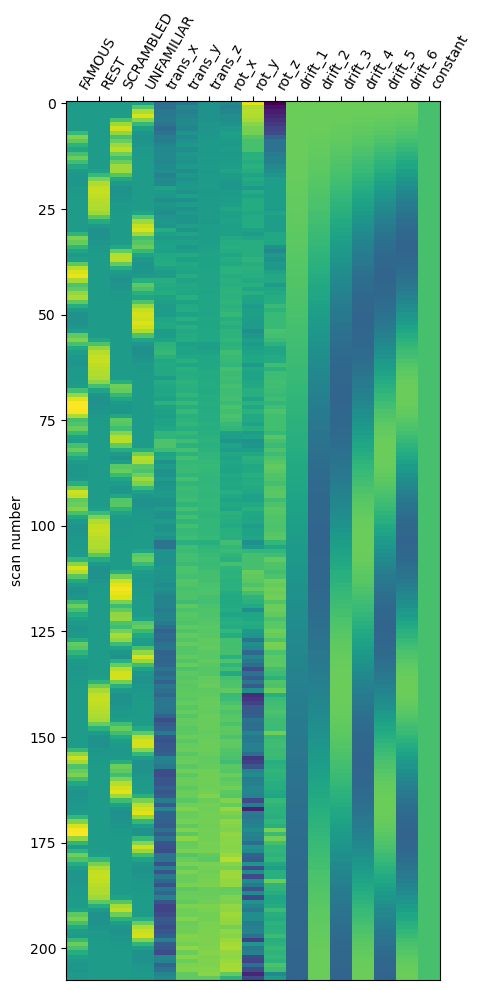

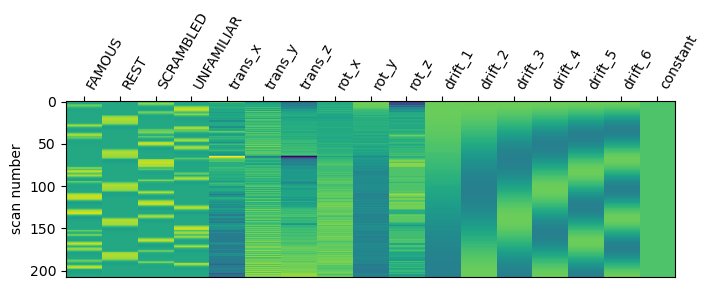

In [25]:
from nilearn.plotting import plot_design_matrix

for dm in design_matrices:
    plot_design_matrix(dm, output_file=None)

import matplotlib.pyplot as plt
fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

### Detecting voxels with significant effects
Now we will compute fixed effects of the 9 runs and generate related images.

#### Contrast specification
If we have the same number of regressors in each run, we can specify the contrast only for one run and it would automatically be reused for other runs.

However, in this dataset we can't do that. One of the subjects have one regressor less (the drift parameter) in one of the runs (because this run was shorter than the other runs; 170 vs 208 volumes).

Therefore, I here create contrasts for each run separately and add them to a list. 

In [26]:
contrast_list = []

for design_matrix in design_matrices:
    
    """A small routine to append zeros in contrast vectors"""
    n_columns = design_matrix.shape[1] #number of predictors in our model
    def pad_vector(contrast_, n_columns):    
        return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))
    
    contrasts = {'Famous_Unfamiliar': pad_vector([1, 0, 0, -1], n_columns),
                'Unfamiliar_Famous': pad_vector([-1, 0, 0, 1], n_columns),
                'Faces_Scrambled': pad_vector([1, 0, -2, 1], n_columns),
                'Scrambled_Faces': pad_vector([-1, 0, 2, -1], n_columns),
                 'EffectsOfInterest': np.eye(n_columns)[[0,2,3]]}
    
    contrast_list.append(contrasts)

Let’s look at the contrasts for the first run.

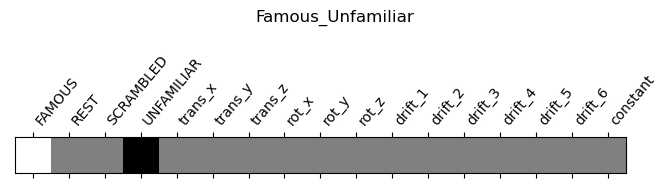

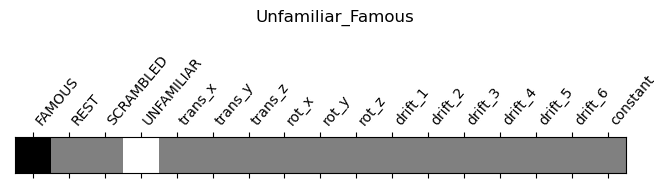

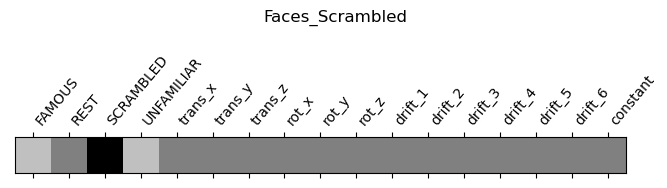

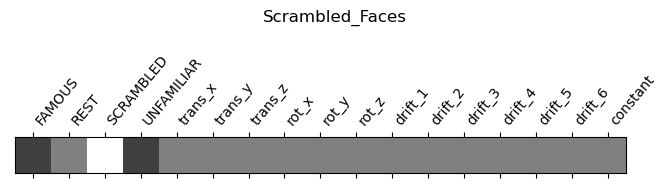

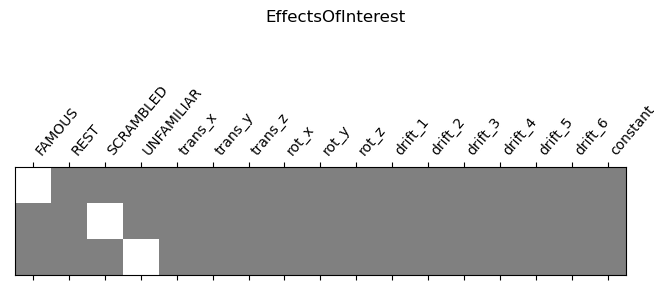

In [27]:
from nilearn.plotting import plot_contrast_matrix
for key, values in contrast_list[0].items():
    plot_contrast_matrix(values, design_matrix=design_matrices[0])
    plt.suptitle(key)

plt.show()

#### Computing resul maps

You can compute the `effect size` maps, `t-statistics` maps, `z-scores` and some other types. See the [documentation](https://nilearn.github.io/dev/modules/generated/nilearn.glm.Contrast.html) for more information.

Below, we compute the estimated effect. It is in BOLD signal unit, but has no statistical guarantees, because it does not take into account the associated variance.

In [28]:
eff_map = fmri_glm.compute_contrast([c['Faces_Scrambled'] for c in contrast_list],
                                    output_type='effect_size')

In order to get statistical significance, we form a `t-statistic`, and directly convert is into `z-scale`. The `z-scale` means that the values are scaled to match a standard Gaussian distribution (mean=`0`, variance=`1`), across voxels, if there were now effects in the data. (To get a `t-map` instead, you'd need to specify `output_type='stat'`.)

In [29]:
z_map = fmri_glm.compute_contrast([c['Faces_Scrambled'] for c in contrast_list],
                                  output_type='z_score')

### Plotting thresholded maps

#### An arbitrary z threshold

Let's display the thresholded z-score map on top of the subject's anatomical image. Let's use arbitrarily a threshold of `3.0` in `z-scale`. We'll see later how to use corrected thresholds. 

See the `plot_stat_map` [documentation](https://nilearn.github.io/dev/modules/generated/nilearn.plotting.plot_stat_map.html) for all the possible parameters you can specify to the plot.

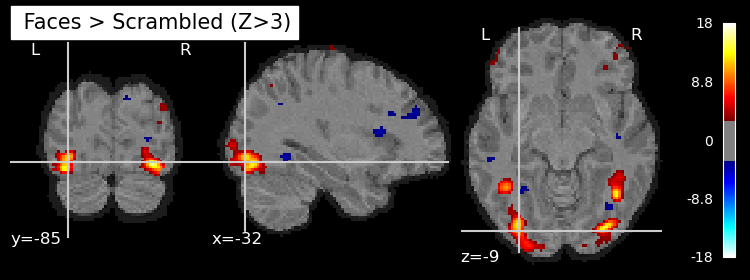

In [32]:
from nilearn.plotting import plot_stat_map, plot_glass_brain

plot_stat_map(
    z_map, 
    bg_img = anat[0], 
    threshold=  3.0,
    display_mode = 'ortho', black_bg=True,
    title =' Faces > Scrambled (Z>3)'
)
plt.show()

We can also plot our maps as glass (trasnparent) brain. 

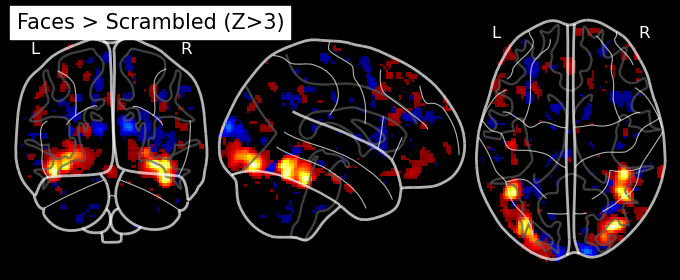

In [33]:
plot_glass_brain(z_map, threshold = 3.0, black_bg = True, plot_abs = False,
                 title='Faces > Scrambled (Z>3)')
plt.show()

### Statistical signifiance testing
One should worry about the statistical validity of the procedure: here we used an arbitrary threshold of 3.0 but the threshold should provide some guarantees on the risk of false detections (aka `type-1` errors in statistics). One
first suggestion is to **control the false positive rate** (`fpr`) at a certain level, e.g. `p < .001`.

#### Control the false positive rate

Uncorrected p<.001 threshold: 3.291


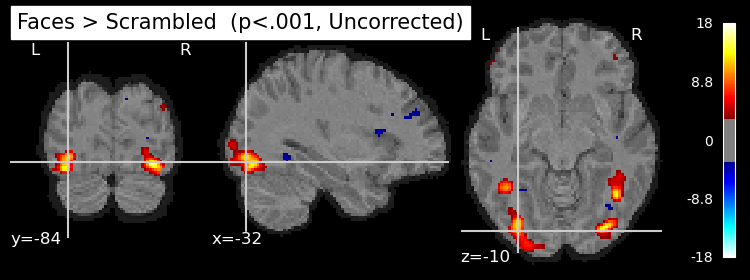

In [34]:
# Obtain the statistical threshold
from nilearn.glm.thresholding import threshold_stats_img

_, threshold = threshold_stats_img(z_map, alpha = .001, height_control = 'fpr')

print('Uncorrected p<.001 threshold: %.3f' % threshold)

# plot the thresholded map
plot_stat_map(z_map, bg_img = anat[0], threshold = threshold,
              display_mode = 'ortho', black_bg = True,
              title = 'Faces > Scrambled  (p<.001, Uncorrected)')
plt.show()

#### Family Wise Error (FWE) correction

The example above is not corrected for **multiple comparisons**. After all, we are performing thousands of `t-tests` here (one for each voxel). A more conservative solution is to control the **family wise error** rate, i.e. the probability of making ony one false detection, say at `5%`. For that we use the so-called `Bonferroni correction`.


Bonferroni-corrected, p<.05 threshold: 5.176


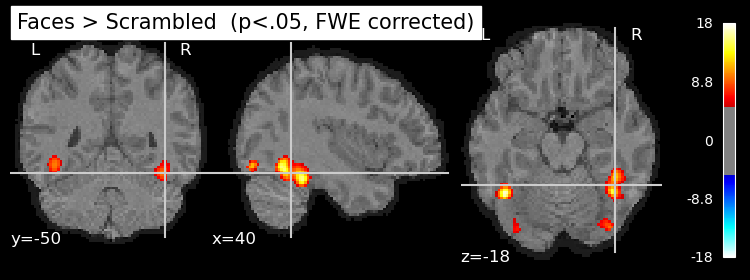

In [35]:
_, threshold = threshold_stats_img(z_map, alpha = .05, height_control = 'bonferroni')

print('Bonferroni-corrected, p<.05 threshold: %.3f' % threshold)

plot_stat_map(z_map, bg_img = anat[0], threshold = threshold,
              display_mode = 'ortho', black_bg = True,
              title = 'Faces > Scrambled  (p<.05, FWE corrected)')
plt.show()

This is quite conservative.

#### False Discovery Rate (FDR) correction

A popular alternative is to control the **false discovery rate**, i.e. the expected proportion of false discoveries among detections. This is called the false disovery rate. `height_control='fdr`.

FDR, p<.05 threshold: 3.361


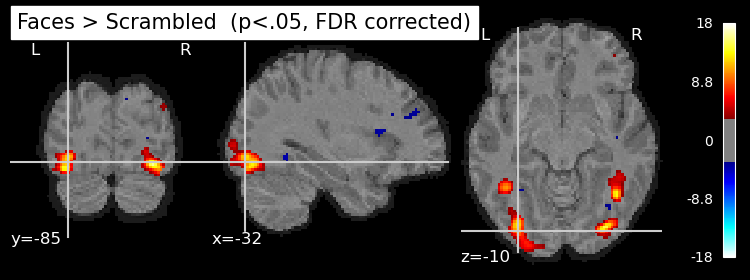

In [36]:
_, threshold = threshold_stats_img(z_map, alpha = .05, height_control = 'fdr')

print('FDR, p<.05 threshold: %.3f' % threshold)

plot_stat_map(z_map, bg_img = anat[0], threshold = threshold,
              display_mode = 'ortho', black_bg = True,
              title = 'Faces > Scrambled  (p<.05, FDR corrected)')
plt.show()

#### Cluster threshold

It's a common practice to discard isolated voxels from the images. It is possible to generate a thresholded map with small clusters removed by providing a `cluster_threshold` argument. Here clusters smaller than `20` voxels will be discarded from the `FDR` corrected map.

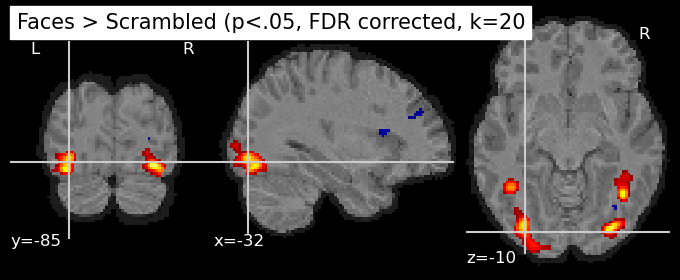

In [37]:
cluster_map, threshold = threshold_stats_img(
    z_map, alpha = .05, height_control='fdr', cluster_threshold = 20)

plot_stat_map(cluster_map, bg_img=anat[0], threshold=threshold,
              display_mode='ortho', black_bg=True, colorbar=False,
              title='Faces > Scrambled (p<.05, FDR corrected, k=20')
plt.show()

### Maps for all contrasts

Computing contrasts
Contrast: Famous_Unfamiliar


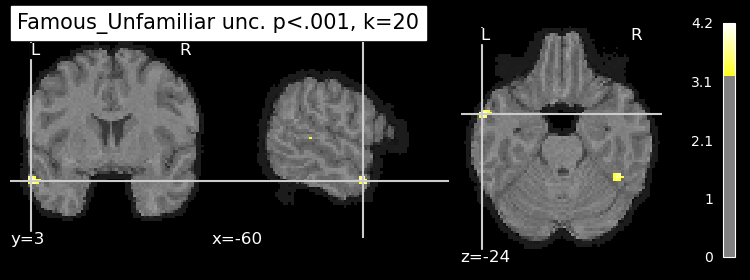

Contrast: Unfamiliar_Famous
	 Unfamiliar_Famous has no significant voxels.
Contrast: Faces_Scrambled


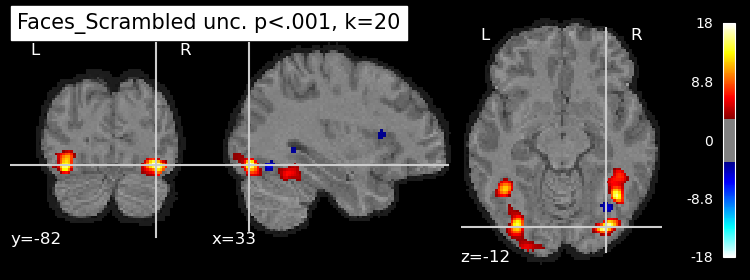

Contrast: Scrambled_Faces


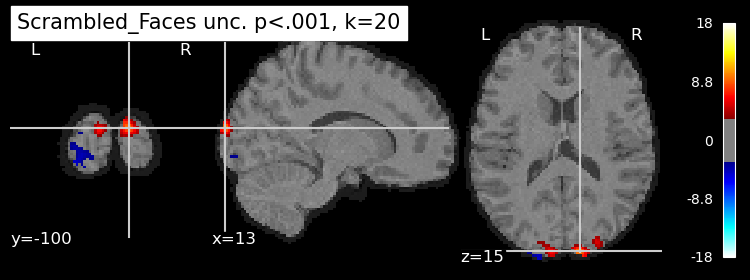

Contrast: EffectsOfInterest


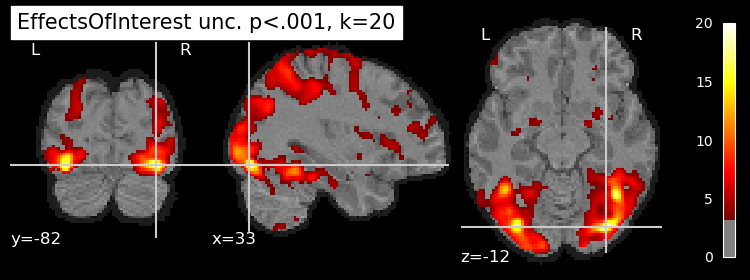

In [39]:
print('Computing contrasts')
import warnings
from nilearn import plotting
from nilearn.reporting import get_clusters_table

# Avoid getting warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Iterate on contrasts
    for contrast_id in contrast_list[0].keys():
        print("Contrast: %s" % contrast_id)
        # compute the contrasts
        z_map = fmri_glm.compute_contrast(
            [c[contrast_id] for c in contrast_list], output_type='z_score')
        # get threshold
        cluster_map, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr', cluster_threshold=20)
        # get peak clusters    
        peaks = get_clusters_table(z_map, stat_threshold=threshold,
                               cluster_threshold=20)
        try: 
            peak_xyz = peaks.loc[0, ['X', 'Y','Z']]
            # plot
            plotting.plot_stat_map(
                cluster_map, 
                bg_img = anat[0], 
                threshold = threshold, 
                display_mode='ortho',
                cut_coords = peak_xyz, 
                black_bg = True, 
                title = contrast_id + ' unc. p<.001, k=20')
            plotting.show()
        except KeyError:
            print('\t', contrast_id, 'has no significant voxels.')
    

### Let's visually compare different models

For example,
* with vs without slice_time_ref adjusted
* different hrf models (contrasts might need adjusting!)
* noise models
* different confounds

To make it a bit faster, let's take subject's native space image (it has lower resolution - less voxels). 

In [40]:
sID = '04'
anat = layout.get(subject=sID, datatype='anat', desc='preproc', extension='.nii.gz', \
                  return_type='filename')
bold = layout.get(subject=sID, datatype='func', space='T1w', desc='preproc', extension='.nii.gz', \
                 return_type='filename') 

A reminder, what confounds we have.

In [48]:
confounds_run1.head(1)

,global_signal,global_signal_derivative1,global_signal_power2,global_signal_derivative1_power2,csf,csf_derivative1,csf_power2,csf_derivative1_power2,white_matter,white_matter_derivative1,...,motion_outlier02,motion_outlier03,motion_outlier04,motion_outlier05,motion_outlier06,motion_outlier07,motion_outlier08,motion_outlier09,motion_outlier10,motion_outlier11
0,767.645558,NaN,589279.703154,NaN,1132.014386,NaN,1.281457e+06,NaN,749.81053,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

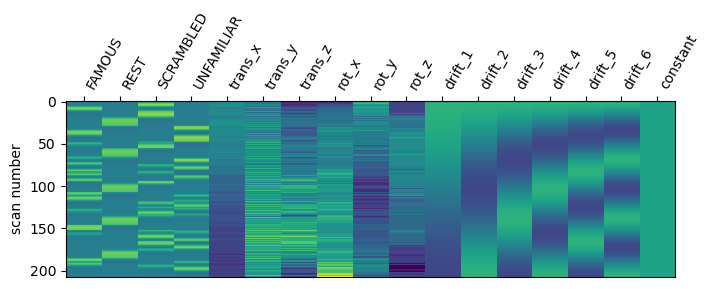

In [61]:
import warnings;
warnings.filterwarnings('ignore');

fmri_glm = FirstLevelModel(
    t_r = TR,
    slice_time_ref = TR/2,
    hrf_model = 'spm',
    drift_model = 'Cosine',
    high_pass = 1./128,
    smoothing_fwhm = 6,
    noise_model = 'ar1', 
    minimize_memory = False
)

fmri_glm = fmri_glm.fit(bold[:4], events[:4], confounds_glm[:4])
design_matrices = fmri_glm.design_matrices_
plot_design_matrix(design_matrices[0], output_file=None)
fig = plt.gcf()
fig.set_size_inches(8,2)
plt.show()

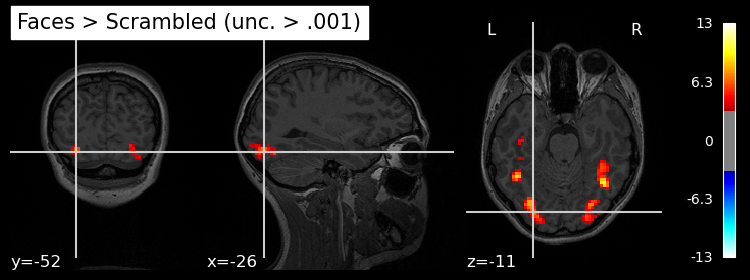

In [62]:
contrast_list = []
for design_matrix in design_matrices:
    """A small routine to append zeros in contrast vectors"""
    n_columns = design_matrix.shape[1] #number of predictors in our model
    def pad_vector(contrast_, n_columns):    
        return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))
    
    contrasts = {'Faces_Scrambled': pad_vector([1, 0, -2, 1], n_columns)}
    contrast_list.append(contrasts)

z_map = fmri_glm.compute_contrast([c['Faces_Scrambled'] for c in contrast_list],
                                      output_type='z_score')
    
_, threshold = threshold_stats_img(z_map, alpha=.001, height_control='fpr')
    
plot_stat_map(z_map, bg_img=anat[0], threshold=threshold,
                  display_mode='ortho', black_bg=True,
                  title='Faces > Scrambled (unc. > .001)')
plt.show()

## First Level for multiple subjects

`first_level.py`

```python
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# ======================================================================
# Dace Apšvalka (MRC CBU 2022)
# First level fMRI analysis using Nilearn
# ======================================================================

# ======================================================================
# IMPORT RELEVANT PACKAGES
# ======================================================================
import os
import sys
import pandas as pd
import numpy as np
from bids.layout import BIDSLayout
from nilearn.glm.first_level import FirstLevelModel

# ======================================================================
# DEFINE PATHS
# ======================================================================
ds = sys.argv[1] # dataset location
sID = sys.argv[2].split("sub-")[1]  
bids_path = os.path.join(ds, 'data/bids')
outdir = os.path.join(ds, 'results/first-level', 'sub-' + sID)
if not os.path.exists(outdir):
    os.makedirs(outdir)

# ======================================================================
# PERFORM SUBJECT LEVEL GLM ANALYSIS
# ======================================================================

# Initialize the BIDS layout and include the derivatives in it
layout = BIDSLayout(bids_path, derivatives=True)

# Get the TR value
TR = layout.get_tr()

# Define the GLM model
fmri_glm = FirstLevelModel(t_r = TR,
                           noise_model = 'ar1',
                           hrf_model = 'spm',
                           drift_model = 'Cosine',
                           high_pass = 1./128,
                           slice_time_ref = TR/2, 
                           smoothing_fwhm = 6,
                           signal_scaling = False,
                           minimize_memory = False)

# Get the preprocessed functional files
bold = layout.get(subject=sID, datatype='func', space='MNI152NLin2009cAsym', desc='preproc', extension='.nii.gz', \
                 return_type='filename')

# Get the event files
events = layout.get(subject=sID, datatype='func', suffix='events', extension=".tsv", return_type='filename')
# Get the confounds and select which ones to include in the design
confounds = layout.get(subject=sID, datatype='func', desc='confounds', extension=".tsv", return_type='filename')
confounds_of_interest = ['trans_x', 'trans_y', 'trans_z', 'rot_x', 'rot_y', 'rot_z']
confounds_glm = []
for conf_file in confounds:
    this_conf = pd.read_table(conf_file)
    conf_subset = this_conf[confounds_of_interest].fillna(0) # replace NaN with 0
    confounds_glm.append(conf_subset)

# Fit the model
fmri_glm = fmri_glm.fit(bold, events, confounds_glm)

# Create contrasts
design_matrices = fmri_glm.design_matrices_

contrast_list = []
for design_matrix in design_matrices:
    """A small routine to append zeros in contrast vectors"""
    n_columns = design_matrix.shape[1] #number of predictors in our model
    def pad_vector(contrast_, n_columns):    
        return np.hstack((contrast_, np.zeros(n_columns - len(contrast_))))
    contrasts = {'FamousUnfamiliar': pad_vector([1, 0, 0, -1], n_columns),
                'UnfamiliarFamous': pad_vector([-1, 0, 0, 1], n_columns),
                'FacesScrambled': pad_vector([1, 0, -2, 1], n_columns),
                'ScrambledFaces': pad_vector([-1, 0, 2, -1], n_columns),
                'EffectsOfInterest': np.eye(n_columns)[[0,2,3]]}
    contrast_list.append(contrasts)

# Compute the contrasts
stats_type = ['effect_size', 'stat']
for stats in stats_type:
    for contrast_id in contrast_list[0].keys():    
        stats_map = fmri_glm.compute_contrast(
            [c[contrast_id] for c in contrast_list], 
            output_type = stats)
        # Save results following BIDS standart
        res_name = os.path.basename(bold[0]).split("run")[0]
        stats_map.to_filename(os.path.join(outdir, res_name + 'desc-' + contrast_id + '_' + stats + '.nii.gz'))
```

`batch_first-level.sh`

```bash
#!/bin/bash
# set -eu
# project path
PROJECT_PATH=${1}

# get the subject list 
SUBJECT_DIRS=("$PROJECT_PATH"/data/bids/sub-*)
SUBJECT_LIST=("${SUBJECT_DIRS[@]##*/}") 

# process in parallel
for sub in "${SUBJECT_LIST[@]}"
do
     srun "$PROJECT_PATH"/code/analysis/first_level.py "${PROJECT_PATH}" ${sub} &
done
wait
```